# Naive Bayes Amazon 

**OBJECTIVE:**

*   TO FIND THE OPTIMAL VALUE OF 'alpha'(Hyperparameter)
*   TO FIND THE ACCURACY SCORE OF OUR PREDICTION ON TEST DATASET.

**NOTE:**


*   Dataset is preprocessed and time-based splitted(Train , Test , Cross-Validate).
*   SAMPLE_SIZE: 100000 Reviews (70K-TRAIN , 15K-CROSS_VALIDATE , 15K-TEST).
*   As a part of feature engineering , we have build a model where length of review is also taken into account for both BOWs and TFIDF models.





IMPORTING LIBRARIES AND OUR DATASET

In [0]:
import numpy as np
import pandas as pd
import math 
import seaborn as sn
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from prettytable import PrettyTable

IMPORTING THE PREPROCESSED AND TIME_BASED SPLITTED DATASET

In [0]:
Train=joblib.load('TRAIN.joblib')
CrossVal=joblib.load('CROSS_VALIDATE.joblib')
Test=joblib.load('TEST.joblib')

In [0]:
Train_x=Train['Text'].values
CrossVal_x=CrossVal['Text'].values
Test_x=Test['Text'].values
Train_y=Train['Score'].values
CrossVal_y=CrossVal['Score'].values
Test_y=Test['Score'].values

In [0]:
Train_len=[]
for i in Train_x:
  Train_len.append(len(i.split()))

In [0]:
CrossVal_len=[]
for i in CrossVal_x:
  CrossVal_len.append(len(i.split()))

In [0]:
Test_len=[]
for i in Test_x:
  Test_len.append(len(i.split()))

**1. BAG OF WORDS**

In [0]:
count= CountVectorizer()

In [0]:
count.fit(Train_x)
Train_BOW = count.transform(Train_x)
CrossVal_BOW = count.transform(CrossVal_x)
Test_BOW= count.transform(Test_x) 

**1.1. Only considering the text reviews.**

**Hyperparameter( alpha ) tuning .**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_BOW, Train_y)
  Train_y_pred =  naive_b.predict_proba(Train_BOW)[:,1]
  Train_AUC_BOW.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_BOW)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

In [0]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

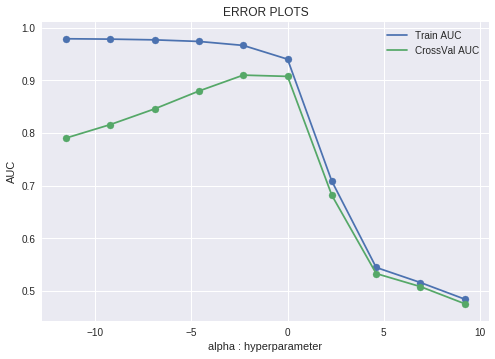

In [49]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [50]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

0.1


The optimal value of 'alpha' obtained is 0.1.

In [0]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_BOW, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_BOW)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_BOW)[:,1])

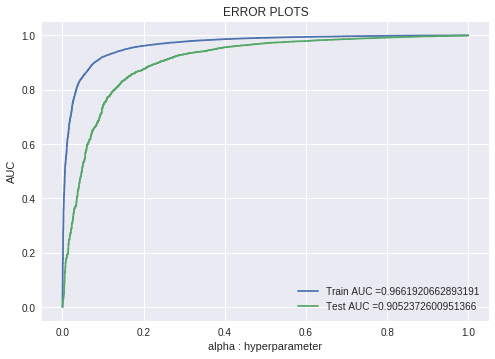

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


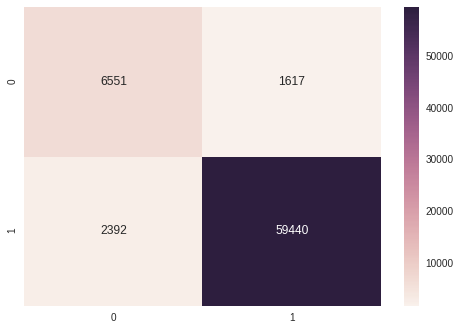

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_BOW))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


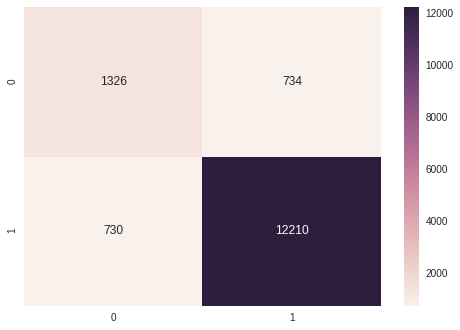

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_BOW))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

Getting the top feature words of each class.

In [0]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :]).argsort()
print("Top 10 negative class words")
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(count.get_feature_names(), pos_class_prob_sorted[0:10]))


Top 10 negative class words
['not' 'like' 'product' 'taste' 'would' 'one' 'good' 'no' 'flavor' 'tea']

Top 10 positive class words
['like' 'good' 'great' 'tea' 'one' 'taste' 'flavor' 'product' 'love'
 'would']


**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with alpha=0.1 on Test Dataset is  13536(90.24%).
2. The Area Under Curve value for Test Dataset is 0.90523(approx) which is quite high.
3. The BOW method takes very less time for computation.

**1.2 Considering the text reviews and length of reviews .**

In [0]:
Train_BOW_len = (hstack((Train_BOW,np.array(Train_len)[:,None]))).tocsr()

In [0]:
CrossVal_BOW_len = (hstack((CrossVal_BOW,np.array(CrossVal_len)[:,None]))).tocsr()

In [0]:
Test_BOW_len = (hstack((Test_BOW,np.array(Test_len)[:,None]))).tocsr()

**Hyperparameter( alpha ) tuning .**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_BOW_len, Train_y)
  Train_y_pred =  naive_b.predict_proba(Train_BOW_len)[:,1]
  Train_AUC_BOW.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_BOW_len)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

In [0]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

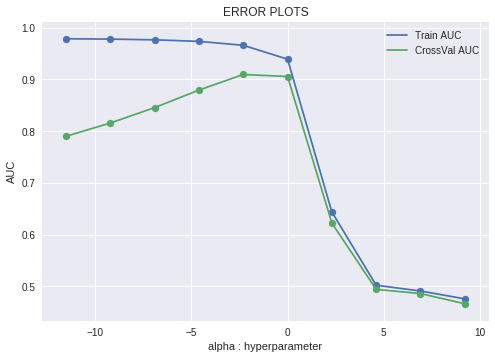

In [57]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [58]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

0.1


The optimal value of 'alpha' obtained is 0.1.

In [0]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_BOW_len, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_BOW_len)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_BOW_len)[:,1])

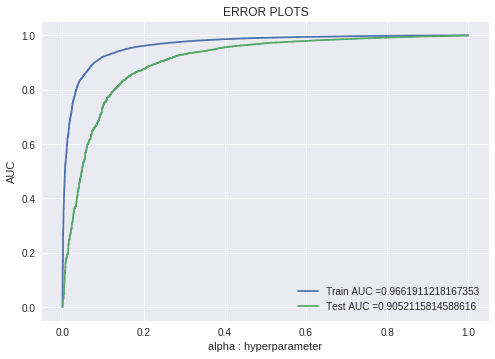

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


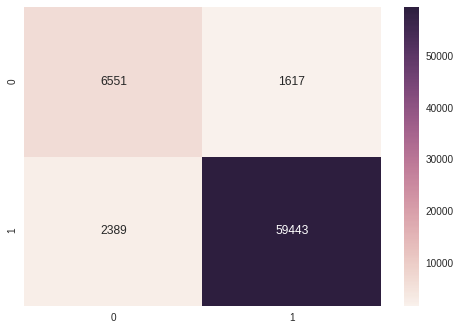

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_BOW_len))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


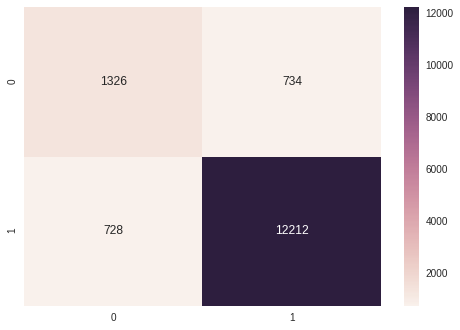

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_BOW_len))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

Getting the top feature words of each class.

In [0]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :49443]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :49443]).argsort()
print("Top 10 negative class words")
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(count.get_feature_names(), pos_class_prob_sorted[0:10]))

Top 10 negative class words
['not' 'like' 'product' 'taste' 'would' 'one' 'good' 'no' 'flavor' 'tea']

Top 10 positive class words
['like' 'good' 'great' 'tea' 'one' 'taste' 'flavor' 'product' 'love'
 'would']


**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with alpha=0.1 on Test Dataset is  13538(90.25%) which is little more than above model.
2. The Area Under Curve value for Test Dataset is 0.90521(approx) which is quite high.
3. The BOW method takes very less time for computation.

**2. TF-IDF**

In [0]:
tf_idf=TfidfVectorizer(ngram_range=(1,2))

In [0]:
tf_idf.fit(Train_x)
Train_TFIDF = tf_idf.transform(Train_x)
CrossVal_TFIDF = tf_idf.transform(CrossVal_x)
Test_TFIDF= tf_idf.transform(Test_x) 

**2.1. Only considering the text reviews.**

**Hyperparameter( alpha ) tuning .**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_TFIDF, Train_y)
  Train_y_pred =  naive_b.predict_proba(Train_TFIDF)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_TFIDF)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

In [0]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

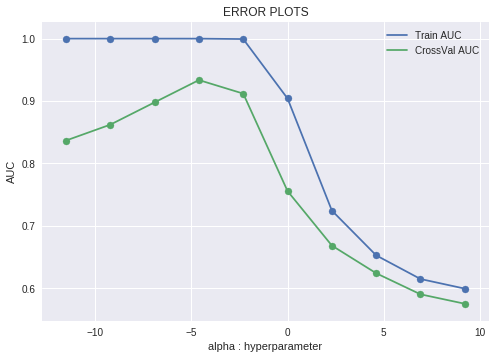

In [63]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

0.01


The optimal value of 'alpha' obtained is 0.01.

In [0]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_TFIDF, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_TFIDF)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_TFIDF)[:,1])

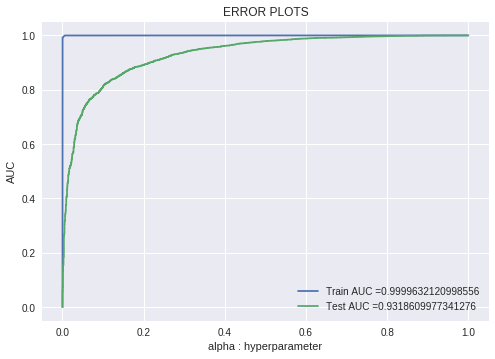

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


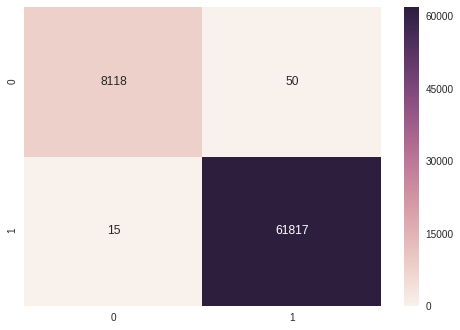

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_TFIDF))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


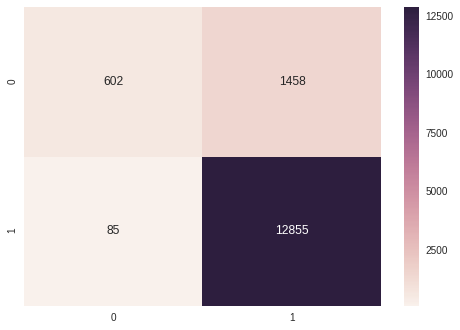

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_TFIDF))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

Getting the top feature words of each class.

In [0]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :]).argsort()
print("Top 10 negative class words")
print(np.take(tf_idf.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(tf_idf.get_feature_names(), pos_class_prob_sorted[:10]))

Top 10 negative class words
['not' 'like' 'product' 'taste' 'would' 'one' 'no' 'flavor' 'good' 'tea']

Top 10 positive class words
['great' 'tea' 'good' 'like' 'love' 'product' 'taste' 'one' 'flavor'
 'coffee']


**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with alpha=0.01 on Test Dataset is  13,457(89.71%) which is little less than above BOW models.
2. The Area Under Curve value for Test Dataset is 0.93186(approx) which is little greater than above BOW models.
3. The TFIDF method takes very less time for computation.

**2.2 Considering the text reviews and length of reviews .**

In [0]:
Train_TFIDF_len = (hstack((Train_TFIDF,np.array(Train_len)[:,None]))).tocsr()

In [0]:
CrossVal_TFIDF_len = (hstack((CrossVal_TFIDF,np.array(CrossVal_len)[:,None]))).tocsr()

In [0]:
Test_TFIDF_len = (hstack((Test_TFIDF,np.array(Test_len)[:,None]))).tocsr()

**Hyperparameter( alpha ) tuning .**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_TFIDF_len, Train_y)
  Train_y_pred =  naive_b.predict_proba(Train_TFIDF_len)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_TFIDF_len)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

In [0]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

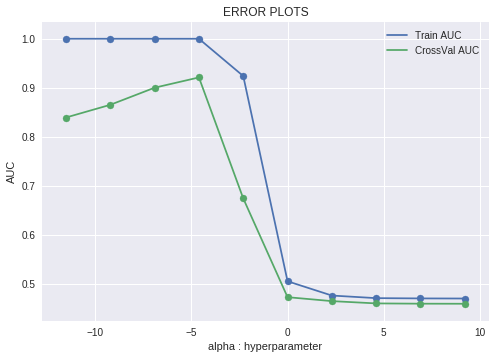

In [68]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

0.01


The optimal value of 'alpha' obtained is 0.01.

In [0]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_TFIDF_len, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_TFIDF_len)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_TFIDF_len)[:,1])

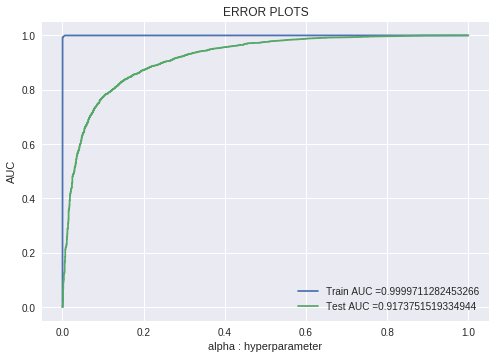

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


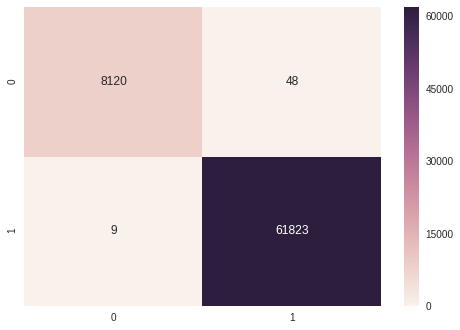

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_TFIDF_len))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


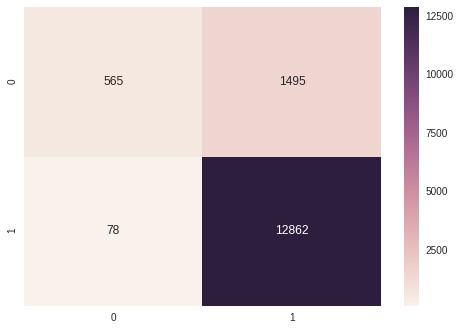

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_TFIDF_len))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

Getting the top feature words of each class.

In [0]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :1125531]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :1125531]).argsort()
print("Top 10 negative class words")
print(np.take(tf_idf.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(tf_idf.get_feature_names(), pos_class_prob_sorted[:10]))

Top 10 negative class words
['not' 'like' 'product' 'taste' 'would' 'one' 'no' 'flavor' 'good' 'tea']

Top 10 positive class words
['great' 'tea' 'good' 'like' 'love' 'product' 'taste' 'one' 'flavor'
 'coffee']


**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with alpha=0.01 on Test Dataset is  13,427(89.51%) which is little less than above TFIDF model.
2. The Area Under Curve value for Test Dataset is 0.91737(approx) which is little less than above TFIDF model.
3. The TFIDF method takes very less time for computation.

**FINAL TABLE**

In [0]:
x = PrettyTable()
x.field_names = ["VECTORIZER","LENGTH-INCLUDED","HYPER PARAMETER:-alpha", "AREA UNDER CURVE"]
x.add_row(["BOW","NO",0.1,0.90523])
x.add_row(["BOW","YES",0.1, 0.90521])
x.add_row(["TFIDF","NO",0.01,0.93186])
x.add_row(["TFIDF","YES",0.01,0.91737])
print(x)

+------------+-----------------+------------------------+------------------+
| VECTORIZER | LENGTH-INCLUDED | HYPER PARAMETER:-alpha | AREA UNDER CURVE |
+------------+-----------------+------------------------+------------------+
|    BOW     |        NO       |          0.1           |     0.90523      |
|    BOW     |       YES       |          0.1           |     0.90521      |
|   TFIDF    |        NO       |          0.01          |     0.93186      |
|   TFIDF    |       YES       |          0.01          |     0.91737      |
+------------+-----------------+------------------------+------------------+


**Summary :**


1.   Our first model BOW , is build using only the text reviews of our dataset . After hyperparameter( alpha ) tuning , we get the value of alpha as 0.1 and then we tested our model on test reviews , were we get the AUC value of 0.90523 . Confusion matrix on train and test dataset is also plotted .
2.   Our second model BOW , is build using the text reviews of our dataset as well as we have considered the length of reviews as one of the features also. After hyperparameter( alpha ) tuning , we get the value of alpha as 0.1 and then we tested our model on test reviews , were we get the AUC value of 0.90521 . Confusion matrix on train and test dataset is also plotted .
3.   Our third model TFIDF , is build using only the text reviews of our dataset . After hyperparameter( alpha ) tuning , we get the value of alpha as 0.01 and then we tested our model on test reviews , were we get the AUC value of 0.93186 . Confusion matrix on train and test dataset is also plotted .
4.   Our forth model TFIDF , is build using the text reviews of our dataset as well as we have considered the length of reviews as one of the features also. After hyperparameter( alpha ) tuning , we get the value of alpha as 0.01 and then we tested our model on test reviews , were we get the AUC value of 0.91737 . Confusion matrix on train and test dataset is also plotted .





**Conclusion:**
*   TFIDF models works better than BOWs models .
*   TFIDF model not containing review length as a feature is the best model with AUC value 0.93186.
*   BOWs model containing review length also as a feature has the lowest value of AUC(  0.90521 ) among all the models.
*   Naive Bayes Algorithm works better than KNN algorithm on text data .





**............................................................................................................................................END...............................................................................................**